In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
cd /content/drive/MyDrive/NLP_BTC

/content/drive/.shortcut-targets-by-id/1P15s6adsZBRPVAJ0fRrx0KqQxM8SiYw8/NLP_BTC


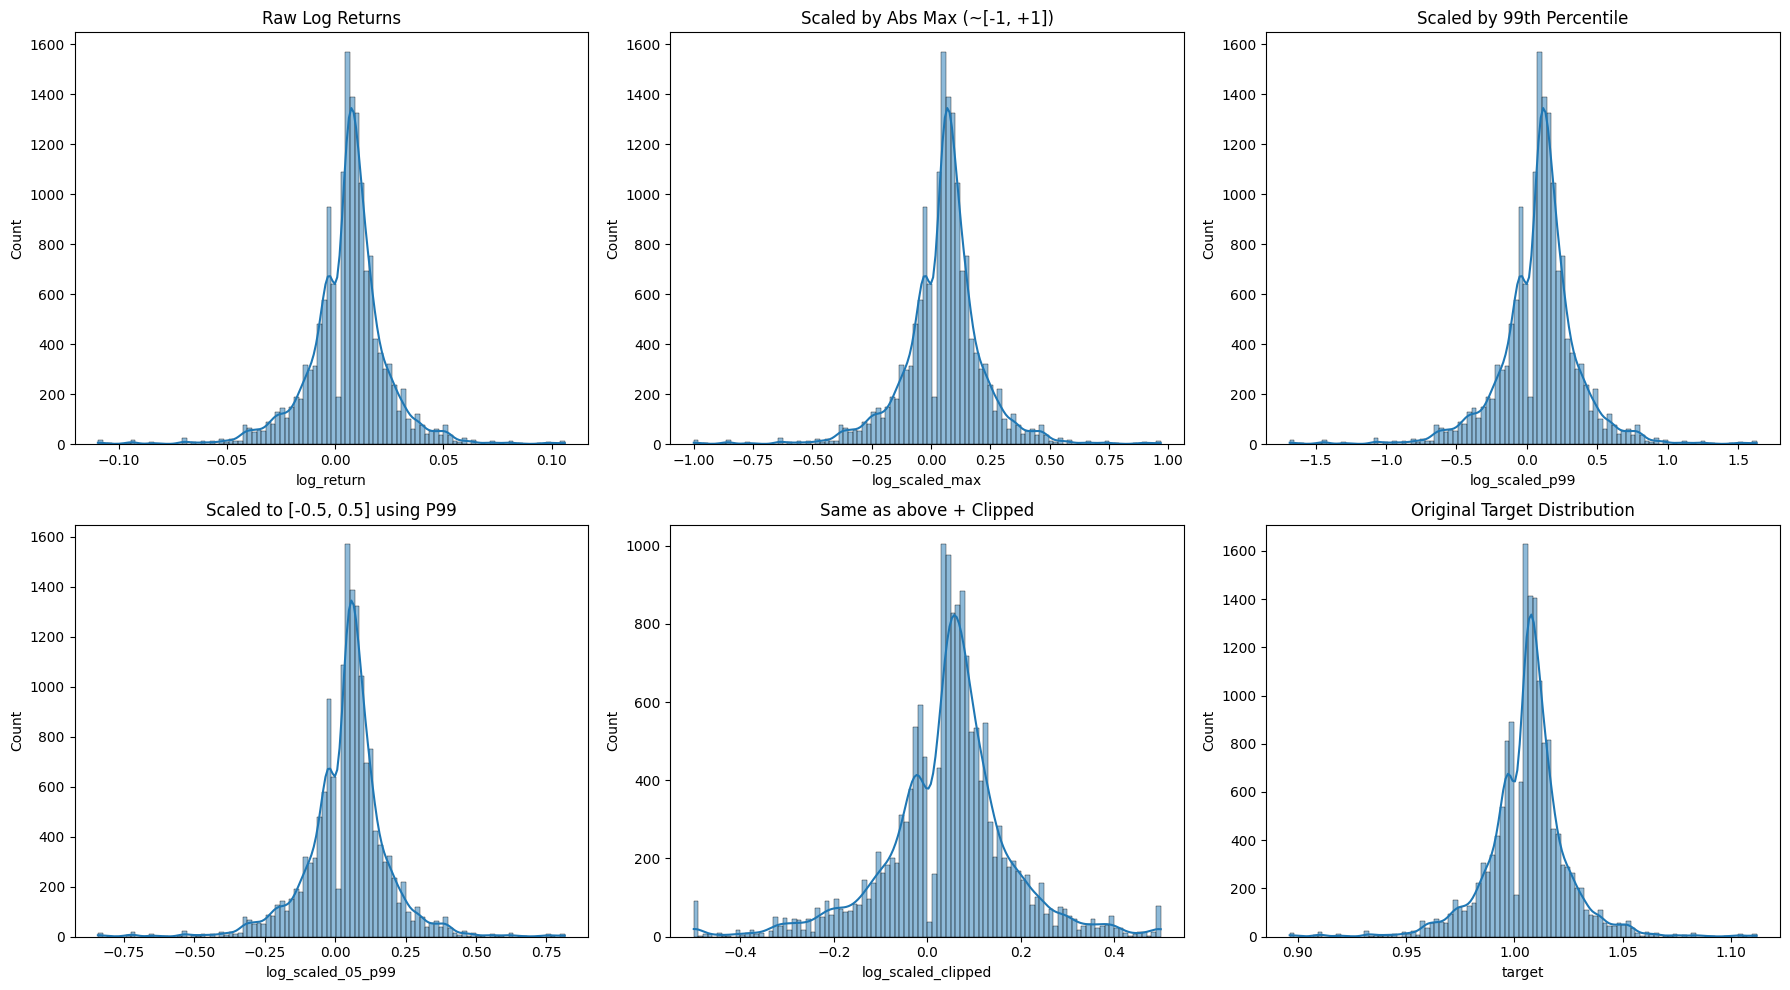

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming df["target"] contains price changes (like 0.97 to 1.04)
df = pd.read_csv("tweets_dataset_v.csv")
log_ret = np.log(df["target"])
df["log_return"] = log_ret

# Scaling factors
abs_max = np.max(np.abs(log_ret))
p99_abs = np.percentile(np.abs(log_ret), 99)

# Scaled targets
df["log_scaled_max"] = log_ret / abs_max
df["log_scaled_p99"] = log_ret / p99_abs
df["log_scaled_05_p99"] = 0.5 * log_ret / p99_abs  # for ~[-0.5, 0.5] range

# Optional clipping
df["log_scaled_clipped"] = np.clip(df["log_scaled_05_p99"], -0.5, 0.5)

# Plotting
fig, axes = plt.subplots(2, 3, figsize=(18, 10))

sns.histplot(df["log_return"], bins=100, kde=True, ax=axes[0, 0])
axes[0, 0].set_title("Raw Log Returns")

sns.histplot(df["log_scaled_max"], bins=100, kde=True, ax=axes[0, 1])
axes[0, 1].set_title("Scaled by Abs Max (~[-1, +1])")

sns.histplot(df["log_scaled_p99"], bins=100, kde=True, ax=axes[0, 2])
axes[0, 2].set_title("Scaled by 99th Percentile")

sns.histplot(df["log_scaled_05_p99"], bins=100, kde=True, ax=axes[1, 0])
axes[1, 0].set_title("Scaled to [-0.5, 0.5] using P99")

sns.histplot(df["log_scaled_clipped"], bins=100, kde=True, ax=axes[1, 1])
axes[1, 1].set_title("Same as above + Clipped")

# Optional: plot untransformed target
sns.histplot(df["target"], bins=100, kde=True, ax=axes[1, 2])
axes[1, 2].set_title("Original Target Distribution")

plt.tight_layout()
plt.show()


In [ ]:
import torch
import pandas as pd
import os
from torch import nn
from torch.utils.data import Dataset
from transformers import (
    BertTokenizer, BertModel,
    Trainer, TrainingArguments,
    EarlyStoppingCallback
)
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
import json

# Config
PRETRAINED_MODEL = "yiyanghkust/finbert-pretrain"
MAX_LEN = 128
BATCH_SIZE = 16
EPOCHS = 9


# Dataset personalizado
class TweetPriceDataset(Dataset):
    def __init__(self, texts, targets, tokenizer):
        self.texts = texts
        self.targets = targets
        self.tokenizer = tokenizer

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        encoding = self.tokenizer(
            self.texts[idx],
            truncation=True,
            max_length=MAX_LEN,
            padding="max_length",  # <= IMPORTANTE
            return_tensors=None
        )
        return {
            "input_ids": torch.tensor(encoding["input_ids"], dtype=torch.long),
            "attention_mask": torch.tensor(encoding["attention_mask"], dtype=torch.long),
            "labels": torch.tensor(self.targets[idx], dtype=torch.float)
        }
#funcion de perdida
from torch.nn.functional import smooth_l1_loss

class AsymmetricHuberLoss(nn.Module):
    def __init__(self, penalty=1.0, delta=1.0, neg_penalty_multiplier=2.0):
        super().__init__()
        self.penalty = penalty
        self.delta = delta
        self.neg_penalty_multiplier = neg_penalty_multiplier

    def forward(self, preds, targets):
        huber = smooth_l1_loss(preds, targets, reduction='none', beta=self.delta)
        signs_match = ((preds >= 0) & (targets >= 0)) | ((preds < 0) & (targets < 0))

        # Apply asymmetric penalty
        wrong_signs = ~signs_match
        is_target_neg = targets < 0
        extra_penalty = self.penalty * (1 + torch.abs(preds - targets))

        # Higher penalty for negative target mismatches
        adjusted_penalty = torch.where(is_target_neg & wrong_signs,
                                       extra_penalty * self.neg_penalty_multiplier,
                                       extra_penalty)

        total_loss = huber * (1 + wrong_signs.float() * adjusted_penalty)
        return total_loss.mean()

loss_fn = AsymmetricHuberLoss()
# Modelos
class FinBERTRegressor_128(nn.Module):
    def __init__(self, model_name):
        super().__init__()
        self.bert = BertModel.from_pretrained(model_name)
        self.regressor = nn.Sequential(
            nn.Linear(self.bert.config.hidden_size, 128),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(128, 1)
        )

    def forward(self, input_ids, attention_mask, labels=None):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        cls = outputs.last_hidden_state[:, 0, :]
        pred = self.regressor(cls).squeeze(-1)
        if labels is not None:
            loss = loss_fn(pred,labels)
            return {"loss": loss, "logits": pred}
        return {"logits": pred}



def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    preds = predictions.flatten()
    labels = labels.flatten()

    mse = mean_squared_error(labels, preds)
    mae = mean_absolute_error(labels, preds)
    r2 = r2_score(labels, preds)
    corr, _ = pearsonr(labels, preds)

    # Sign accuracy (directional match)
    correct_signs = ((preds > 0) == (labels > 0)).mean()

    # Binary classification logic based on sign
    pred_pos = preds > 0
    label_pos = labels > 0
    pred_neg = ~pred_pos
    label_neg = ~label_pos

    # Positive class
    tp_pos = (pred_pos & label_pos).sum()
    fp_pos = (pred_pos & label_neg).sum()
    fn_pos = (pred_neg & label_pos).sum()
    precision_pos = tp_pos / (tp_pos + fp_pos) if (tp_pos + fp_pos) > 0 else 0.0
    recall_pos = tp_pos / (tp_pos + fn_pos) if (tp_pos + fn_pos) > 0 else 0.0

    # Negative class
    tp_neg = (pred_neg & label_neg).sum()
    fp_neg = (pred_neg & label_pos).sum()
    fn_neg = (pred_pos & label_neg).sum()
    precision_neg = tp_neg / (tp_neg + fp_neg) if (tp_neg + fp_neg) > 0 else 0.0
    recall_neg = tp_neg / (tp_neg + fn_neg) if (tp_neg + fn_neg) > 0 else 0.0

    return {
        "mse": mse,
        "mae": mae,
        "r2": r2,
        "pearson": corr,
        "accuracy": correct_signs,
        "precision_pos": precision_pos,
        "recall_pos": recall_pos,
        "precision_neg": precision_neg,
        "recall_neg": recall_neg
    }
def evaluate_on(dataset, name="Dataset"):
    predictions = trainer.predict(dataset)
    preds = predictions.predictions.flatten()
    labels = predictions.label_ids.flatten()

    r2 = r2_score(labels, preds)
    correct_signs = ((preds > 0) == (labels > 0)).mean()

    print(f"📊 {name} — R²: {r2:.4f}, Accuracy: {correct_signs*100:.2f}%")
    return r2, correct_signs

# Cargar dataset
df = pd.read_csv("tweets_dataset_v.csv")
log_return = np.log(df["target"])
p99 = np.percentile(np.abs(log_return), 99)
scale = 0.5 / p99
df["target_scaled"] = log_return * scale
df["target_scaled"] = np.clip(df["target_scaled"], -0.5, 0.5)

# Total rows and 20% split
n = len(df["target_scaled"])
print(n)
val_split = int(n * 0.2)

# Split without shuffling, minimizing pair breakage
val_df = df.iloc[:val_split]
train_df = df.iloc[val_split:]

#shuffle only train
train_df = train_df.sample(frac=1.0, random_state=42).reset_index(drop=True)
# Convert to lists for model input
train_texts = train_df["tweet"].tolist()
train_targets = train_df["target_scaled"].tolist()

val_texts = val_df["tweet"].tolist()
val_targets = val_df["target_scaled"].tolist()

"""train_texts, val_texts, train_targets, val_targets = train_test_split(
    df['tweet'].tolist(), df['target_scaled'].tolist(), test_size=0.3,shuffle=True, random_state=42
)"""

#train_targets = np.array(train_targets).reshape(-1, 1)
"""n_components = 4
gmm = GaussianMixture(n_components=n_components, random_state=42)
gmm.fit(train_targets)

probs = gmm.predict_proba(train_targets)
component_means = gmm.means_.flatten()
train_targets = (probs @ component_means).astype(np.float32)"""



tokenizer = BertTokenizer.from_pretrained(PRETRAINED_MODEL)
train_dataset = TweetPriceDataset(train_texts, train_targets, tokenizer)
val_dataset = TweetPriceDataset(val_texts, val_targets, tokenizer)

from transformers import DataCollatorWithPadding

# Crear el collator con el tokenizer
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

# Args de entrenamiento
def get_training_args(run_name):
    return TrainingArguments(
        output_dir=f"./results_{run_name}",
        # evaluación
        do_eval=True,
        eval_strategy="steps",
        eval_steps=200,
        per_device_eval_batch_size=BATCH_SIZE,

        # logging y checkpoints
        logging_steps=200,
        save_steps=2000,
        save_total_limit=2,

        learning_rate=1e-4,
        weight_decay=0.15,
        max_grad_norm=1.0,

        per_device_train_batch_size=BATCH_SIZE,
        num_train_epochs=EPOCHS,

        load_best_model_at_end=True,
        metric_for_best_model="accuracy",
        greater_is_better=True,
        logging_dir=f"./logs_{run_name}",
        report_to="none",
        fp16=torch.cuda.is_available(),
        lr_scheduler_type="linear",  # ✅ Linear warmup + decay
        warmup_steps=100
    )

# Entrenar y guardar resultados
results = {}

for model_name, model_class in {
    "128": FinBERTRegressor_128,
    #"256_64": FinBERTRegressor_256_64
}.items():
    print(f"\n🔧 Entrenando modelo: {model_name}")
    model = model_class(PRETRAINED_MODEL)

    trainer = Trainer(
        model=model,
        args=get_training_args(model_name),
        train_dataset=train_dataset,
        eval_dataset=val_dataset,
        tokenizer=tokenizer,
        data_collator=data_collator,
        compute_metrics=compute_metrics
        #callbacks=[EarlyStoppingCallback(early_stopping_patience=15)]
    )

    trainer.train()
    evaluate_on(train_dataset, "Train")
    evaluate_on(val_dataset, "Validation")
 # ✅ Guardar el mejor modelo
    best_model_path = f"./saved_models/{model_name}"
    os.makedirs(best_model_path, exist_ok=True)
    torch.save(model.state_dict(), os.path.join(best_model_path, "pytorch_model.bin"))
    tokenizer.save_pretrained(best_model_path)
    print(f"✅ Mejor modelo '{model_name}' guardado en: {best_model_path}")

    # 🧹 (Opcional) Limpiar checkpoints intermedios
    import shutil, os
    for folder in os.listdir(trainer.args.output_dir):
        if folder.startswith("checkpoint") or folder == "runs":
            shutil.rmtree(os.path.join(trainer.args.output_dir, folder), ignore_errors=True)

      # 📈 Guardar logs para graficar luego
    logs = trainer.state.log_history

    train_loss = [x["loss"] for x in logs if "loss" in x and "eval_loss" not in x]
    eval_loss = [x["eval_loss"] for x in logs if "eval_loss" in x]

    # Extraer R² si está presente
    eval_r2 = [x["eval_r2"] for x in logs if "eval_r2" in x]

    # Guardar todos los valores por modelo
    results = {
        "train_loss": train_loss,
        "eval_loss": eval_loss,
        "eval_r2": eval_r2
    }
    # Convert the flat dict into a one-row DataFrame
    df_results = pd.DataFrame([results])

    # Save to CSV
    df_results.to_csv("model_results.csv", index=False)


#save logs

pd.DataFrame(trainer.state.log_history).to_csv("log_history.csv", index=False)



15983

🔧 Entrenando modelo: 128


/tmp/ipython-input-7-3553626666.py:246: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Step,Training Loss,Validation Loss,Mse,Mae,R2,Pearson,Accuracy,Precision Pos,Recall Pos,Precision Neg,Recall Neg
200,0.020600,0.011940,0.014017,0.079413,0.226561,0.486296,0.816020,0.838292,0.901252,0.757127,0.639076
400,0.012700,0.011092,0.014900,0.082845,0.177863,0.451368,0.796934,0.967162,0.723690,0.623262,0.948989
600,0.011900,0.014804,0.014303,0.079715,0.210786,0.505041,0.744994,0.733635,0.976820,0.845679,0.263715
800,0.010700,0.010259,0.013768,0.077826,0.240343,0.508635,0.842616,0.952903,0.806676,0.695620,0.917228
1000,0.010400,0.013446,0.014073,0.083617,0.223486,0.540203,0.814768,0.804120,0.959203,0.858748,0.514918
1200,0.009300,0.009751,0.013227,0.076753,0.270189,0.526585,0.856696,0.912179,0.871581,0.755947,0.825794
1400,0.009900,0.010381,0.013160,0.078884,0.273891,0.546105,0.861076,0.919236,0.870654,0.758023,0.841193
1600,0.008700,0.010199,0.013600,0.076105,0.249599,0.524348,0.853254,0.958198,0.818266,0.710487,0.925890
1800,0.008800,0.011083,0.013371,0.076354,0.262212,0.513759,0.853880,0.920817,0.857209,0.740741,0.846968
2000,0.008500,0.009887,0.013132,0.076059,0.275406,0.531696,0.858573,0.943318,0.840983,0.730558,0.895091


📊 Train — R²: 0.9431, Accuracy: 98.92%


📊 Validation — R²: 0.3277, Accuracy: 85.95%
✅ Mejor modelo '128' guardado en: ./saved_models/128


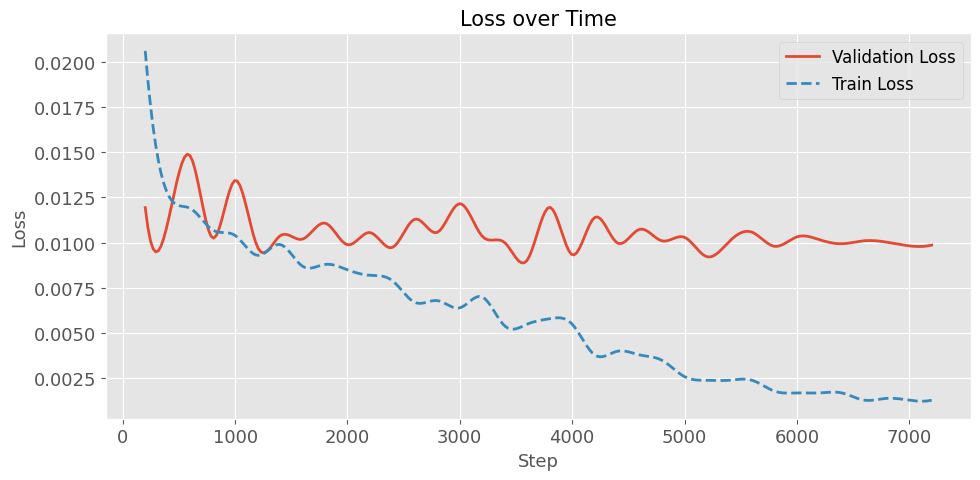

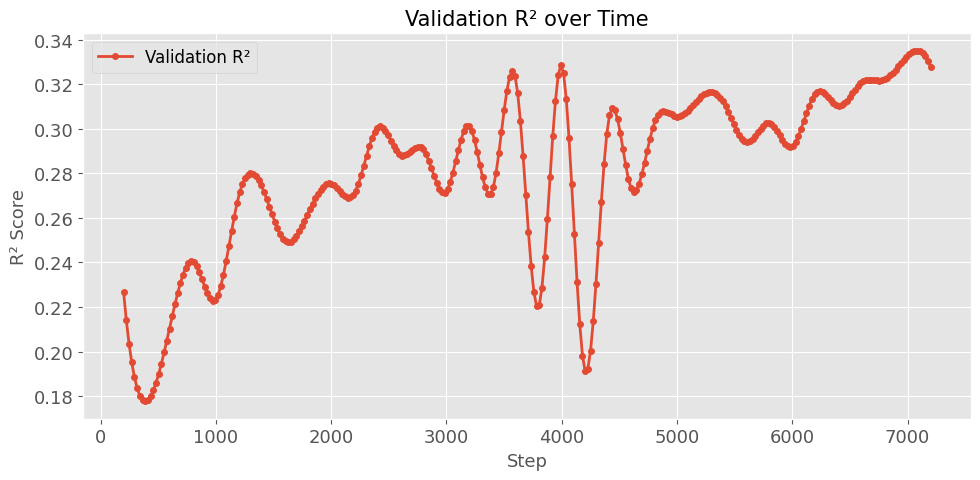

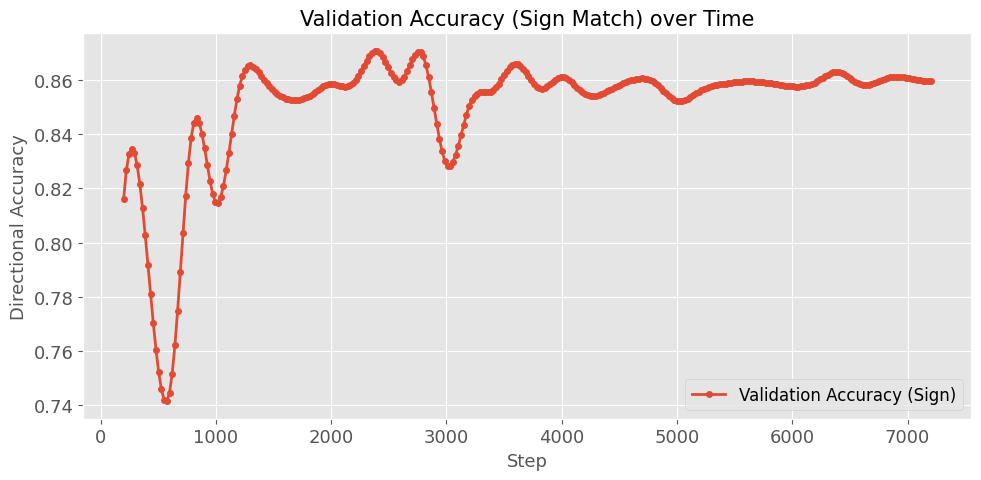

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.interpolate import make_interp_spline

# 📥 Cargar log_history
log_df = pd.read_csv("log_history.csv")

# Separar train y eval
train_df = log_df[log_df["loss"].notnull()]
eval_df = log_df[log_df["eval_loss"].notnull()]

# --- 🔢 Datos
train_steps = train_df["step"].tolist()
train_loss = train_df["loss"].tolist()

eval_steps = eval_df["step"].tolist()
eval_loss = eval_df["eval_loss"].tolist()
eval_r2 = eval_df["eval_r2"].tolist()
eval_acc = eval_df["eval_accuracy"].tolist()

# --- 🎨 Estilo general
plt.style.use("ggplot")
plt.rcParams.update({
    "font.size": 13,
    "axes.labelsize": 13,
    "axes.titlesize": 15,
    "legend.fontsize": 12
})

def smooth_curve(x, y, points=300):
    """Interpolar para suavizar la curva"""
    x = np.array(x)
    y = np.array(y)
    if len(x) < 4:  # evitar problemas con poca data
        return x, y
    x_new = np.linspace(x.min(), x.max(), points)
    spline = make_interp_spline(x, y, k=3)
    y_smooth = spline(x_new)
    return x_new, y_smooth

# --- 📈 1. Validation vs. Train Loss
plt.figure(figsize=(10, 5))
x_eval, y_eval = smooth_curve(eval_steps, eval_loss)
x_train, y_train = smooth_curve(train_steps, train_loss)
plt.plot(x_eval, y_eval, label="Validation Loss", linewidth=2)
plt.plot(x_train, y_train, label="Train Loss", linewidth=2, linestyle="--")
plt.xlabel("Step")
plt.ylabel("Loss")
plt.title("Loss over Time")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# --- 📈 2. Validation R²
plt.figure(figsize=(10, 5))
x_r2, y_r2 = smooth_curve(eval_steps, eval_r2)
plt.plot(x_r2, y_r2, label="Validation R²", linewidth=2, marker="o", markersize=4)
plt.xlabel("Step")
plt.ylabel("R² Score")
plt.title("Validation R² over Time")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# --- 📈 3. Validation Accuracy (Sign Match)
plt.figure(figsize=(10, 5))
x_acc, y_acc = smooth_curve(eval_steps, eval_acc)
plt.plot(x_acc, y_acc, label="Validation Accuracy (Sign)", linewidth=2, marker="o", markersize=4)
plt.xlabel("Step")
plt.ylabel("Directional Accuracy")
plt.title("Validation Accuracy (Sign Match) over Time")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()




In [ ]:
params = {
    "p99": float(p99),
    "scale": float(scale),
    "clip_min": -0.5,
    "clip_max": 0.5
}
with open("params.json", "w") as f:
    json.dump(params, f)

📊 MÉTRICAS SOBRE PREDICCIONES CON MAE <= 0.005
📉 MSE:           0.000060
📉 MAE:           0.006818
🔗 Pearson:       0.334021
✅ Sign accuracy: 70.37%


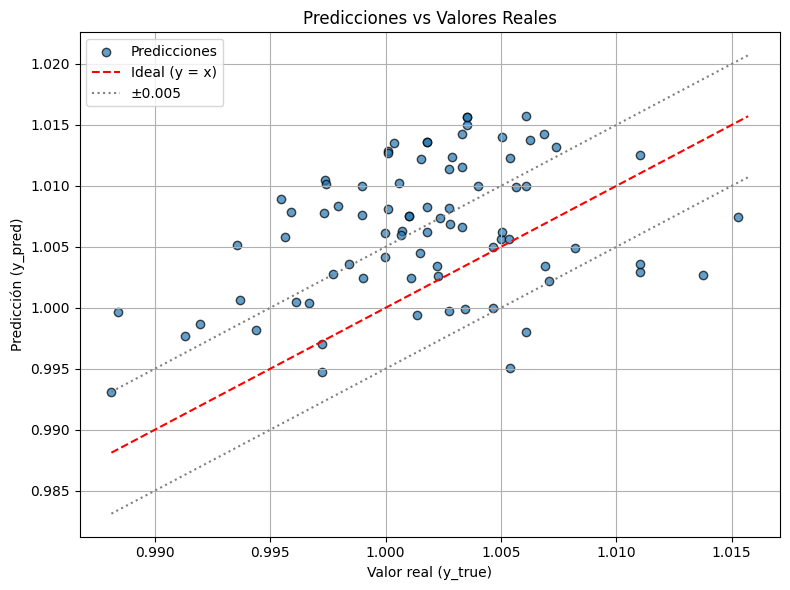

In [10]:
import torch
import pandas as pd
import numpy as np
from transformers import BertTokenizer
from torch.utils.data import DataLoader, Dataset
from transformers import DataCollatorWithPadding
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from scipy.stats import pearsonr
import json

# --- 🔧 Configuración ---
MODEL_NAME = "128"
PRETRAINED_MODEL = "yiyanghkust/finbert-pretrain"
MODEL_PATH = f"./saved_models/{MODEL_NAME}"
BATCH_SIZE = 32
MAX_LEN = 128

# --- 🧠 Clase del modelo ---
class FinBERTRegressor_128(torch.nn.Module):
    def __init__(self, model_name):
        super().__init__()
        from transformers import BertModel
        self.bert = BertModel.from_pretrained(model_name)
        self.regressor = torch.nn.Sequential(
            torch.nn.Linear(self.bert.config.hidden_size, 128),
            torch.nn.ReLU(),
            torch.nn.Dropout(0.4),
            torch.nn.Linear(128, 1)
        )

    def forward(self, input_ids, attention_mask, labels=None):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        cls = outputs.last_hidden_state[:, 0, :]
        pred = self.regressor(cls).squeeze(-1)
        return {"logits": pred}

# --- 🔌 Cargar modelo y tokenizer ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = FinBERTRegressor_128(PRETRAINED_MODEL)
model.load_state_dict(torch.load(f"{MODEL_PATH}/pytorch_model.bin", map_location=torch.device("cpu")))

model.to(device)
model.eval()

tokenizer = BertTokenizer.from_pretrained(MODEL_PATH)

# --- 📥 Cargar parámetros de escala ---
with open("params.json", "r") as f:
    params = json.load(f)

scale = params["scale"]
clip_min = params.get("clip_min", -0.5)
clip_max = params.get("clip_max", 0.5)

# --- 📄 Dataset ---
df_test = pd.read_csv("test_predictions.csv")
df_test['Texto'] = df_test['Texto'].replace(r'[\r\n]+', ' ', regex=True).str.strip()
texts_test = df_test["Texto"].tolist()
true_ratio = df_test["Factor_Multiplicacion"].tolist()  # 🔥 Target real

# Dataset y loader
class TweetPriceDataset(Dataset):
    def __init__(self, texts, targets, tokenizer):
        self.texts = texts
        self.targets = targets
        self.tokenizer = tokenizer

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        encoding = self.tokenizer(
            self.texts[idx],
            truncation=True,
            max_length=MAX_LEN,
            padding="max_length",
            return_tensors=None
        )
        return {
            "input_ids": torch.tensor(encoding["input_ids"], dtype=torch.long),
            "attention_mask": torch.tensor(encoding["attention_mask"], dtype=torch.long),
            "labels": torch.tensor(self.targets[idx], dtype=torch.float)
        }

dataset_test = TweetPriceDataset(texts_test, true_ratio, tokenizer)
collator = DataCollatorWithPadding(tokenizer=tokenizer)
loader_test = DataLoader(dataset_test, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collator)

# --- 🔮 Hacer predicciones ---
all_preds = []
all_labels = []

with torch.no_grad():
    for batch in loader_test:
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["labels"].to(device)

        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        preds = outputs["logits"]

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# --- 🔄 Desescalar predicciones ---
pred_scaled = np.clip(np.array(all_preds), clip_min, clip_max)
pred_log = pred_scaled / scale
pred_ratio = np.exp(pred_log)  # 🔁 predicción final en escala ratio
true_ratio = np.array(all_labels)

# --- 📄 Guardar predicciones en el DataFrame original ---
df_test["pred_ratio"] = pred_ratio
df_test["true_ratio"] = true_ratio


# --- 📊 Calcular métricas ---
mse = mean_squared_error(df_test["true_ratio"], df_test["pred_ratio"])
mae = mean_absolute_error(df_test["true_ratio"], df_test["pred_ratio"])
pearson = pearsonr(df_test["true_ratio"], df_test["pred_ratio"])[0]
sign_acc = (np.sign(df_test["true_ratio"] - 1) == np.sign(df_test["pred_ratio"] - 1)).mean()

print("📊 MÉTRICAS SOBRE PREDICCIONES CON MAE <= 0.005")
print(f"📉 MSE:           {mse:.6f}")
print(f"📉 MAE:           {mae:.6f}")
print(f"🔗 Pearson:       {pearson:.6f}")
print(f"✅ Sign accuracy: {sign_acc*100:.2f}%")





import matplotlib.pyplot as plt

# --- 📈 Scatter Plot: y_true vs y_pred  ---
plt.figure(figsize=(8, 6))
plt.scatter(df_test["true_ratio"], df_test["pred_ratio"], alpha=0.7, edgecolors="k", label="Predicciones")

# Línea ideal y = x
min_val = min(df_test["true_ratio"].min(), df_test["pred_ratio"].min())
max_val = max(df_test["true_ratio"].max(), df_test["pred_ratio"].max())
plt.plot([min_val, max_val], [min_val, max_val], 'r--', label="Ideal (y = x)")

# Líneas de ±0.005 (opcional)
plt.plot([min_val, max_val], [min_val+0.005, max_val+0.005], 'gray', linestyle='dotted', label="±0.005")
plt.plot([min_val, max_val], [min_val-0.005, max_val-0.005], 'gray', linestyle='dotted')

plt.xlabel("Valor real (y_true)")
plt.ylabel("Predicción (y_pred)")
plt.title("Predicciones vs Valores Reales")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()
